In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns

# K-Fold Cross Validation

Crea los k folds (Por cada uno crea 3 csv's: Train, Test y Expected)

In [2]:
def create_k_folds(train, k):
    train = train.sample(frac=1)
    folds = []
    for i in range(k):
        folds.append(train[i*len(train)//k : (i+1)*len(train)//k])
    for i in range(k):
        
        expected = pd.DataFrame().assign(label=folds[i]['label'])
        expected.to_csv('./k-fold/expected_' + str(i) + '.csv', index=False)

        new_test = folds[i]
        new_test.drop(['label'], axis=1).to_csv('./k-fold/test_' + str(i) + '.csv', index=False)

        new_train = pd.concat(folds[:i] + folds[i+1:])
        new_train.to_csv('./k-fold/train_' + str(i) + '.csv', index=False)

Corre el algoritmo de PCA para cada uno de los folds, por cada fold crea un csv: Out

In [90]:
def run_PCA(folds, alpha, k):
    for i in range(folds):
        subprocess.run(['./PCA', f'./k-fold/train_{i}.csv', f'./k-fold/test_{i}.csv', f'./k-fold/out_{i}.csv', str(alpha), str(k)], stdout=subprocess.PIPE, encoding='ascii')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [87]:
folds = 10
create_k_folds(train, folds)

### Pecision, Recall, Confusion Matrix

In [91]:
alpha = 4
k = 5
run_PCA(folds, alpha, k)

In [105]:
accuracy = []
confusion = np.zeros((10, 10), dtype=int)
false_neg = np.zeros(10, dtype=int)
for i in range(folds):
    out = pd.read_csv(f'./k-fold/out_{i}.csv')
    expected = pd.read_csv(f'./k-fold/expected_{i}.csv')
    for j in range(len(out)):
        expected_label = int(expected.iloc[[j]]['label'])
        predicted_label = int(out.iloc[[j]]['Label'])
        confusion[expected_label][predicted_label] += 1
        if expected_label != predicted_label:
            false_neg[expected_label] += 1
    accuracy.append(sum(out['Label'] == expected['label'])/len(out))

In [106]:
TP = np.diag(confusion)
FP = np.sum(confusion, axis=0) - TP
FN = np.sum(confusion, axis=1) - TP
precision = TP / (TP+FP)
recall = TP / (TP+FN)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: [0.6180952380952381, 0.62, 0.6252380952380953, 0.6242857142857143, 0.6114285714285714, 0.6228571428571429, 0.6226190476190476, 0.6183333333333333, 0.6311904761904762, 0.6164285714285714]
Precision: [0.76771564 0.92125493 0.66581437 0.65649964 0.56153279 0.44092769
 0.64034892 0.55233183 0.44597928 0.47194546]
Recall: [0.82066796 0.94662681 0.62341393 0.62330499 0.56139489 0.42582345
 0.69204738 0.58395819 0.44499139 0.42979943]


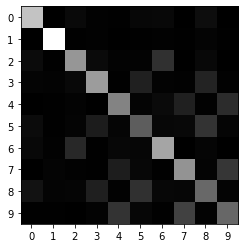

In [96]:
plt.imshow(confusion, cmap='gray')
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0,10));

# PCA metrics

In [31]:
def get_kaggle_accuracy(sub, correct_answers):
    count = 0
    for i in range(len(sub)):
        if int(sub.iloc[[i]]['Label']) == int(correct_answers.iloc[[i]]['Label']):
            count += 1
    return count / len(sub)

In [61]:
kaggle = pd.read_csv('kaggle.csv')

alphas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 35, 40, 45, 50]
ks = [1, 3, 5, 10, 25, 50]

data = pd.DataFrame([], columns=['alpha', 'k', 'accuracy', 'time'])
for alpha in alphas:
    for k in ks:
        time = subprocess.run(['./PCA', 'train.csv', 'test.csv', 'out.csv', str(alpha), str(k)], stdout=subprocess.PIPE, encoding='ascii').stdout.split('\n')[0]
        score = get_kaggle_accuracy(pd.read_csv('out.csv'), kaggle)
        data = data.append({'alpha': alpha, 'k': k, 'accuracy': score, 'time': float(time)}, ignore_index = True)


In [86]:
data.head()

,alpha,k,accuracy,time
0,1,1,0.249107,69.0182
1,1,3,0.254429,69.9108
2,1,5,0.258929,69.9623
3,1,10,0.263821,70.8536
4,1,25,0.268250,70.9766


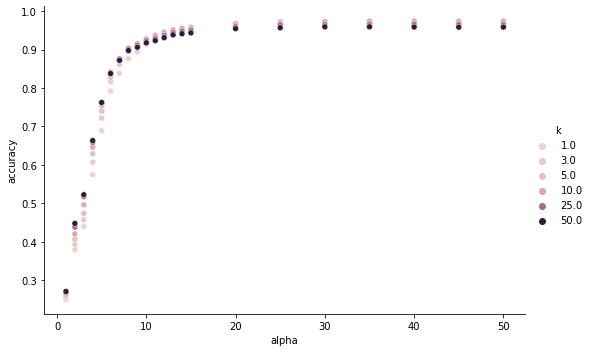

In [68]:
sns.relplot(data=data, x="alpha", y="accuracy", hue="k", aspect=1.5)

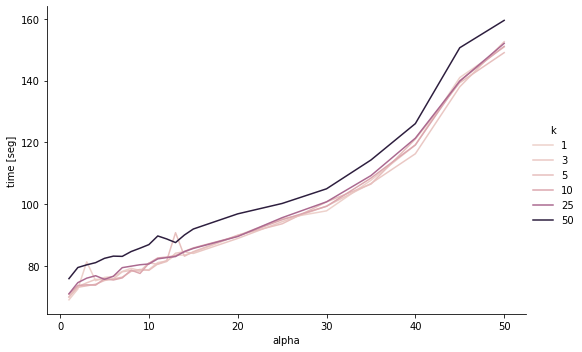

In [95]:
p = sns.relplot(data=data, x="alpha", y="time", hue="k", kind="line", aspect=1.5)
p.set(xlabel='alpha', ylabel='time [seg]')

In [71]:
# El mejor es:
column = data["accuracy"]
max_index = column.idxmax()
data.iloc[[max_index]]

,alpha,k,accuracy,time
127,50.0,3.0,0.975786,152.585
